<h1>Calculating CWUBC</h1>
Jan 2016 <br/>

Given JSON summaries of projects, calculate Cumulative Weighted Unique Block Count (CWUBC) of projects

See Proposal, Page 4: http://benjixie.com/meng_proposal.pdf

REQUIRED: ai2summarizer.py (https://github.com/bxie/ai2_summarizer)

See also: Trajectory.ipynb

CWUBC Steps: <br/>
<ol>
    <li> <strike> parse directory and load JSON from directory </strike> </li>
    <li> <strike>calcualte T_all matrix (see proposal) </strike></li>
    <li> calculate block weighting </li>
</ol>

POPPS Steps: <br/>
<ol>
    <li><strike>Determine blocks corresponding to each programming skill</strike></li>
    <li><strike>Calculate POPPS matrix</strike></li>
</ol>

Clustering:
<ol>
    <li>Separate users based on CWUBC</li>
    <li>Plot POPPS of each group</li>
    <li>Run K-Means clustering on CWUBC trajectory matrix</li>
    <li>Plot POPPS of each cluster</li>    
</ol>

In [237]:
import os
import os.path
import re
import json
import csv
import pickle
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import matplotlib

#making plots look pretty
%matplotlib inline
matplotlib.style.use('ggplot')
pd.options.display.mpl_style = 'default'

from collections import Counter

# ROOT_DIR = "/Users/bxie/Documents/ai2_users_random_small/"
ROOT_DIR = "/Users/bxie/Documents/ai2_users_random/"
NB_DIR = "/Users/bxie/programming/ai2_user_trajectory/data/"
REGEX_ROOT_IGNORE = 'python|\.|README'
REGEX_SUMMARY = 'summary\.json'
SUMMARY_SUFFIX = "_summary.json"

In [238]:
"""
code to get blocks
"""

"""
return dictionary of (user ids, num projects) 
for users w/ at least min_num_projects
"""
def get_users(min_num_projects):
    #regex to ignore non-project files
    ignore = 'python|\.|README'
    regexp=re.compile(ignore) #use: regexp.search(fname)

    fnames = filter(lambda x: regexp.search(x) is None, os.listdir(ROOT_DIR))
    super_users = {}

    for fname in fnames:
        num_projects = len(get_all_projects(fname))
        if num_projects > min_num_projects:
            super_users[fname] = num_projects

    return super_users

"""
Given user_id (user directory name), return list of all project ids
"""
def get_all_projects(user_id):
    unfiltered_project_names = os.listdir("{}{}".format(ROOT_DIR, user_id))
    project_names = filter(lambda x: x.isdigit(), unfiltered_project_names)
    return project_names

"""
given user id and project id, return project summary (as dictionary)
"""
def get_summary(user_id, project_id):
    summary_dir = "{}{}/{}{}".format(ROOT_DIR, user_id, project_id, SUMMARY_SUFFIX)
    with open(summary_dir) as data_file:
        data = json.load(data_file)
    return data

"""
Given project_id (user directory name), return lists of all active blocks, orphaned blocks
"""
def get_blocks(summary):
    screen_names = filter(lambda x: x.find("*")<0, summary.keys())
    blocks_count = Counter({})
    orphan_count = Counter({})
    for sname in screen_names:
        #if has blocks
        if has_blocks(summary, sname):
            blocks_count += Counter(summary[sname]['Blocks']['Active Blocks']['Types'])
        if has_blocks(summary, sname, check_active=False):
            orphan_count += Counter(summary[sname]['Blocks']['Orphan Blocks']['Types'])
    return dict(blocks_count), dict(orphan_count)

"""
Given blocks dict, save to CSV
"""
def save_blocks_to_csv(blocks_dict, new_fname_path):
    writer = csv.writer(open("{}.csv".format(new_fname_path), 'wb'))
    for key, value in blocks_dict.items():
        writer.writerow([key, value])
    return True


""""""""""""""" Helper Functions """""""""""""""

"""
Given project summary(dict) and screen name(str) 
and designation of active (default) or orphan blocks,
return boolean to determine if screen has those blocks
"""
def has_blocks(summary, screen_name, check_active=True):
    block_name = 'Active Blocks' if check_active else 'Orphan Blocks'
    return type(summary[screen_name]['Blocks']) == dict and type(summary[screen_name]['Blocks'][block_name]) == dict

In [239]:
""" Get all types of blocks """

"""
get count of all blocks by users with at least n (threshold) projects
"""
def get_all_blocks(threshold=0):
    counter_active = Counter({})
    counter_orphan = Counter({})    
    
    for user_id in get_users(threshold):
        for project_id in get_all_projects(user_id):
#             print "{}, {}".format(user_id, project_id)
            active, orphan = get_blocks(get_summary(user_id, project_id))
            counter_active += Counter(active)
            counter_orphan += Counter(orphan)
    return dict(counter_active), dict(counter_orphan)

"""
get list of all block types
"""
def get_all_block_types(active_blocks, orphan_blocks):
    return list(set(active_blocks.keys() + orphan_blocks.keys()))

def load_block_types(fname):
    block_types = open(fname, 'rb')
    output = pickle.load(block_types)
    block_types.close()
    return output

def save_block_types(block_types_list, fname):
    block_types = open(fname, 'wb')
    pickle.dump(block_types_list, block_types)
    block_types.close()

In [241]:
"""
Calculating trajectory matrix (CWUBC)
"""

# order of this is important
block_types_fname = 'jeff_types.pkl'
BLOCK_TYPES = load_block_types(NB_DIR+block_types_fname)
THRESHOLD = 20

def get_all_trajectories(threshold=THRESHOLD):
    user_ids = get_users(threshold)
    user_traj_vectors = [] #list of user trajectory vectors
    for uid in user_ids:
        V_u = get_trajectory(uid)
        user_traj_vectors.append(V_u)
    return np.vstack(user_traj_vectors)

# given a user_id, return trajectory as vector of # of blocks used at each project
# BXX TODO: Add weighting
def get_trajectory(user_id, threshold=THRESHOLD):
    P_b = get_binary_matrix(user_id, threshold)
    V_u = np.sum(P_b, axis=1)
    return V_u

def get_binary_matrix(user_id, threshold=THRESHOLD):
    P_u = get_freq_matrix(user_id, threshold)
    # print P_u[:, BLOCK_TYPES.index('color_make_color')]
    P_c = np.cumsum(P_u, axis = 0)
    # print P_c[:, BLOCK_TYPES.index('color_make_color')]
    return P_c>0
    

# given user_id, return matrix of frequency of blocks of each project 
# output: n x d matrix where n=# of projects (THRESHOLD), d = # of block types
def get_freq_matrix(user_id, threshold=THRESHOLD):
#     print "{}".format(user_id)
    output = np.zeros((threshold, len(BLOCK_TYPES)))
    project_ids = get_all_projects(user_id)[:threshold] # getting first n projects from user
    for i in range(threshold):
        pid = project_ids[i]
        summary = get_summary(user_id, pid)
        blocks = get_blocks(summary)[0]
#         print blocks
        for blk, count in blocks.items():
            output[i, BLOCK_TYPES.index(blk)] = count
    return output

In [242]:
"""
Calculating POPPS
To get block type, from browser console: bs = Blocklies['5066549580791808_Screen1']; bs.selected.type
"""




#mapping programming skill to blocks id
#NB: If BLOCK_TYPES changes, this will have to change as well
POPPS_MAP = {
    'cond': [
        'controls_if', #conditional
        'controls_choose'
       ], 
    'list': [
        'lists_create_with', #list
        'lists_create_with', 
        'lists_add_items', 
        'lists_is_in', 
        'lists_length', 
        'lists_is_empty', 
        'lists_pick_random_item', 
        'lists_position_in', 
        'lists_select_item', 
        'lists_insert_item', 
        'lists_replace_item', 
        'lists_remove_item', 
        'lists_append_list', 
        'lists_copy', 
        'lists_is_list', 
        'lists_to_csv_row', 
        'lists_to_csv_table', 
        'lists_from_csv_row', 
        'lists_from_csv_table', 
        'lists_lookup_in_pairs'
       ], 
    'loop': [
        'controls_forEach', #loop
        'controls_forRange',
        'controls_while'
       ], 
    'logic': [
        'logic_negate', #operator
        'logic_or', 
        'logic_boolean', 
        'logic_false', 
        'logic_operation', 
        'logic_compare'
       ], 
    'var': [
        'lexical_variable_set', 
        'lexical_variable_get', 
        'local_declaration_expression', 
        'local_declaration_statement'], #variable
    'proc': [
        'procedures_defnoreturn', #procedure
        'procedures_callreturn', 
        'procedures_defreturn', 
        'procedures_callnoreturn'
       ], 
    }

"""
given binary matrix to show POPPS, 
return vector for average proportion of users who have not learned skill by project i
"""
def get_average_survival(popps_matrix):
    return np.average(popps_matrix, axis=0)


"""
given specific programming skill (string) from POPPS_MAP.keys(),
and optional threshold for min number of projects users must have
return binary matrix to show POPPS (row: user, column: 1 if used skill by that project)
"""
def get_popps_all_users(prog_skill, threshold=THRESHOLD, block_types=BLOCK_TYPES):
    user_ids = get_users(threshold)
    user_popps_vectors = [] #list of user trajectory vectors
    for uid in user_ids:
        P_b = get_specific_popps_binary(uid, prog_skill, threshold, block_types)
        user_popps_vectors.append(P_b)
    return np.vstack(user_popps_vectors)

"""
given user id (string),
specific programming skill (string) from POPPS_MAP.keys(),
optional thershold for number of projects to analyze,
and optional block types matrix (block_types_matrix),
return binary matrix for all POPPS that is 1 if user has skill by project i
"""
def get_specific_popps_binary(user_id, prog_skill, threshold=THRESHOLD, block_types= BLOCK_TYPES):
    if prog_skill not in POPPS_MAP:
        raise Exception("{} not in POPPS_MAP. Select from {}".format(prog_skill, POPPS_MAP.keys()))
    popps_binary = np.zeros([1, threshold])
    popps_binary[:] = 1
    P_b = get_binary_matrix(user_id, threshold)
    block_inds = get_block_indices(POPPS_MAP[prog_skill], block_types)
    found_proj_ind = np.argwhere(P_b[:,block_inds]==True) #locations in P_b that show block in project
    if len(found_proj_ind):
        first_proj_ind = np.min(np.argwhere(P_b[:,block_inds]==True)[:,0]) #get first project that contains a block pertaining to prog_skill
        popps_binary[0, first_proj_ind:] = 0
    return popps_binary
        
    
"""
given user id (int as string), 
optional thershold for number of projects to analyze,
and optional block types matrix (block_types_matrix),
return binary matrix for all POPPS that is 1 if user has skill by project i
"""
def get_all_popps_binary(user_id, threshold=THRESHOLD, block_types= BLOCK_TYPES):
    num_popps = len(POPPS_MAP)
    popps_binary = np.zeros([num_popps, threshold])
    popps_binary[:,:] = 1
    for i in range(num_popps):
        prog_skill = POPPS_MAP.keys()[i]
        if prog_skill not in POPPS_MAP:
            raise Exception("{} not in POPPS_MAP. Select from {}".format(prog_skill, POPPS_MAP.keys()))
        P_b = get_binary_matrix(user_id, threshold)
        block_inds = get_block_indices(POPPS_MAP[prog_skill], block_types)
        found_proj_ind = np.argwhere(P_b[:,block_inds]==True) #locations in P_b that show block in project
        if len(found_proj_ind):
            first_proj_ind = np.min(np.argwhere(P_b[:,block_inds]==True)[:,0]) #get first project that contains a block pertaining to prog_skill
            popps_binary[i, first_proj_ind:] = 0
    return popps_binary
    
    
""" HELPER FUNCTIONS """

"""
Given list of block types to identify (selected_blocks)
and optional blocks types matrix (block_types) 
return list of indices in matrix for given types
"""
def get_block_indices(selected_blocks, block_types = BLOCK_TYPES):
    indices = []
    for blk_type in selected_blocks:
        indices.append(block_types.index(unicode(blk_type)))
    return list(set(indices))

In [244]:
# get_block_indices(BLOCK_TYPES, POPPS_MAP['var']) #[32, 562, 380, 397]
# get_block_indices(['lexical_variable_set', 'lexical_variable_get'])
# BLOCK_TYPES.index('math_trig')
# summary = get_summary('000095', '5473318385745920')
# get_blocks(summary)
# raise Exception("'{}' not in POPPS_MAP. Select from {}".format('taco', POPPS_MAP.keys()))
# get_specific_popps_binary('000095', 'logic', 4)
# POPPS_MAP.keys()[0]
x = get_popps_all_users('list')
np.average(x, axis=0)


array([ 0.79432624,  0.64539007,  0.54609929,  0.46099291,  0.43262411,
        0.40425532,  0.36879433,  0.36170213,  0.32624113,  0.31205674,
        0.31205674,  0.30496454,  0.29078014,  0.27659574,  0.26241135,
        0.24822695,  0.22695035,  0.21276596,  0.20567376,  0.19858156])

In [152]:
# pu = get_binary_matrix('000095', 4)
# print pu[:,562]
# x = np.zeros([1,4])
# x[0,1:]=1
# x
type(BLOCK_TYPES[0])


unicode

In [135]:

pb = get_binary_matrix('000095', 4)
print np.argwhere(pb[:,[562, 397]]==True)
print pb[:,[562, 397]]
print
print np.min(np.argwhere(pb[:,[562, 397]]==True)[:,0])

[[2 0]
 [2 1]
 [3 0]
 [3 1]]
[[False False]
 [False False]
 [ True  True]
 [ True  True]]

2


In [240]:
#get all blocks
active, orphan = get_all_blocks(0)
len(active)
all_types = get_all_block_types(active, orphan)

# save block types
# save_blocks_to_csv(active, NB_DIR + "jeff_0_active")
# save_blocks_to_csv(orphan, NB_DIR + "jeff_0_orphan")
# save_block_types(all_types, NB_DIR + "jeff_types.pkl")
print 'all saved!'

all saved!


In [260]:
#get trajectories

T_all = get_all_trajectories(20)

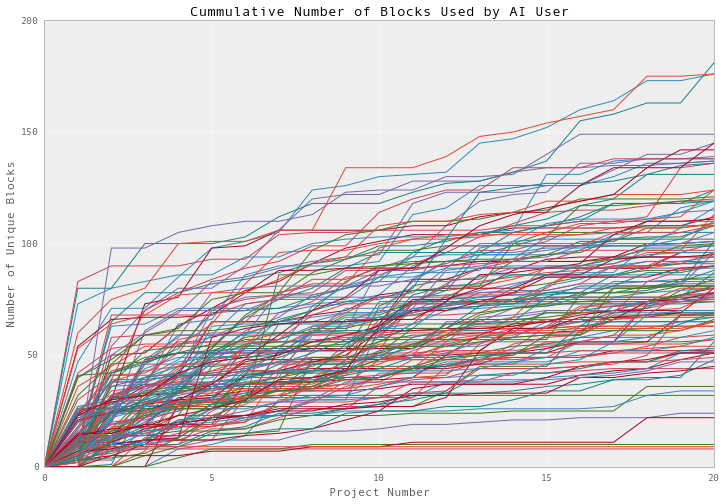

In [262]:
#plotting CWUBC trajectory
plt.figure(figsize=(12,8))
num_users = np.shape(T_all)[0]
T_all_plot = np.insert(T_all, 0, 0, axis=1) #0 added in beginning for plot

# plt.plot(T_all_mean, linestyle='dotted', linewidth=5)
plt.xlabel('Project Number')
plt.ylabel('Number of Unique Blocks')

plt.title("Cummulative Number of Blocks Used by AI User")
for i in range(T_all_plot.shape[0]):
    plt.plot(T_all_plot[i,:])

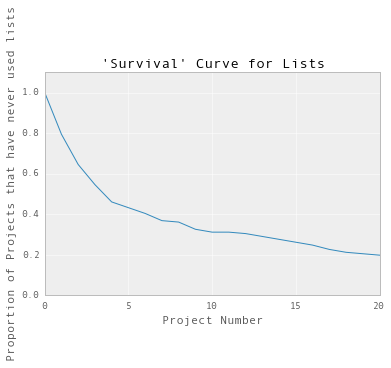

In [263]:
#plotting POPPS
skill = 'lists' #change this
skill_title = 'lists'
popps_matrix = get_popps_all_users('list')
popps_avg = get_average_survival(popps_matrix)
popps_avg = np.insert(popps_avg, 0, 1.0) #included since 0th index is first project

plt.figure()
plt.xlabel('Project Number')
plt.ylabel("Proportion of Projects that have never used {}".format(skill_title))
plt.title("'Survival' Curve for {}".format(skill_title.title()))
plt.ylim([0,1.1])
plt.plot(popps_avg)